In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm

In [2]:
from sklearn.metrics import classification_report

In [3]:
df = pd.read_csv('../../data/processed/WESAD/data_processed/30s/all_data.csv', index_col=0)
df['rulebased_label'] = -1

In [4]:
def detect_focus(hr, hrv, eda, resp_rate):
    HR_MIN = 60       
    HR_MAX = 100       
    HRV_MIN = 30      
    EDA_MIN = 0.05    
    EDA_MAX = 0.5     
    RESP_RATE_MIN = 12  
    RESP_RATE_MAX = 20

    hr_focus = HR_MIN <= hr <= HR_MAX
    hrv_focus = hrv >= HRV_MIN
    eda_focus = EDA_MIN <= eda <= EDA_MAX
    resp_focus = RESP_RATE_MIN <= resp_rate <= RESP_RATE_MAX 

    if hr_focus and hrv_focus and eda_focus and resp_focus:
        return 1  # Focus
    else:
        return 0  # Not focus


In [5]:
for i, row in tqdm(df.iterrows(), total=len(df)):
    hr = float(row['HR'])
    hrv = float(row['SDNN'])
    eda = float(row['EDA_mean'])
    resp_rate = float(row['RESP_rate'])

    focus = detect_focus(hr, hrv, eda, resp_rate)
    df.at[i, 'rulebased_label'] = focus

100%|██████████| 1075/1075 [00:00<00:00, 52963.98it/s]


In [6]:
df.head()

,ACC_x_mean,ACC_y_mean,ACC_z_mean,net_acc_mean,net_acc_std,EDA_mean,EDA_std,EDA_slope,RESP_rate,RESP_regularity,HR,IBI,RMSSD,SDNN,pNN50,lf/hf,label,subject,focus_label,rulebased_label
0,37.715333,-35.027333,-9.694000,62.840001,5.214880,0.630601,0.026678,-0.000766,17.748666,1.755023,75.081294,847.426471,226.949936,186.465391,93.939394,1.475494,1,8,1,0
1,39.252000,-47.664667,7.822000,62.549339,0.544205,0.563131,0.014406,-0.000412,21.083279,1.630067,63.966173,958.669355,213.058396,133.561891,90.000000,5.933398,1,8,1,0
2,39.628667,-46.246667,9.764000,62.469299,1.120992,0.523506,0.009367,-0.000265,21.327375,1.591487,66.372243,911.132812,134.469912,80.095987,74.193548,44.207315,1,8,1,0
3,38.927333,-48.439333,6.083333,62.442314,0.428267,0.520051,0.018623,0.000048,22.168906,1.352590,78.588847,803.631757,159.088795,155.426060,58.333333,707.930928,1,8,1,0
4,38.919333,-47.006667,-0.914667,62.576766,1.166077,0.493109,0.007353,-0.000203,24.011434,1.809602,65.088073,940.020161,199.098718,134.709634,63.333333,6.149627,1,8,1,0


In [7]:
df.value_counts('rulebased_label')

rulebased_label
0    971
1    104
Name: count, dtype: int64

In [8]:
df.value_counts('focus_label')

focus_label
1    595
0    480
Name: count, dtype: int64

In [9]:
features = ['HR', 'EDA_mean', 'RMSSD', 'RESP_rate', 'net_acc_mean']

In [10]:
mask = pd.Series(True, index=df.index)

In [11]:
for subject in df['subject'].unique():
    for label in df['label'].unique():
        sub_df = df[(df['subject'] == subject) & (df['label'] == label)]
        for feature in features:
            q1 = sub_df[feature].quantile(0.25)
            q3 = sub_df[feature].quantile(0.75)
            iqr = q3 - q1
            lower = q1 - 1.5 * iqr
            upper = q3 + 1.5 * iqr
            outlier_mask = (df['subject'] == subject) & (df['label'] == label) & (
                            (df[feature] < lower) | (df[feature] > upper))
            mask[outlier_mask] = False

df = df[mask].reset_index(drop=True)

In [12]:
subjects = df['subject'].unique()

In [13]:
df.value_counts('rulebased_label')

rulebased_label
0    809
1     98
Name: count, dtype: int64

In [14]:
def safe_slope(x):
    if len(x) < 2 or np.all(np.isnan(x)):
        return np.nan
    try:
        return np.polyfit(range(len(x)), x, 1)[0]
    except np.linalg.LinAlgError:
        return np.nan

def add_features_mean_based(df):
    df['hr_diff'] = df['HR'].diff()
    df['hr_center'] = df['HR'] - df['HR'].mean()
    df['hr_slope'] = df['HR'].rolling(window=3, min_periods=2).apply(safe_slope, raw=True)
    df['hr_zscore'] = (df['HR'] - df['HR'].mean()) / df['HR'].std()

    df['lf_hf_log'] = np.log1p(df['lf/hf'])

    df['resp_zscore'] = (df['RESP_rate'] - df['RESP_rate'].mean()) / df['RESP_rate'].std()

    df['EDA_slope_clipped'] = df['EDA_slope'].clip(-0.002, 0.005)
    df['EDA_mean_clip'] = df['EDA_mean'].clip(upper=df['EDA_mean'].quantile(0.99))
    df['EDA_slope_log'] = np.sign(df['EDA_slope_clipped']) * np.log1p(np.abs(df['EDA_slope_clipped']))
    df['EDA_slope_pos'] = (df['EDA_slope'] > 0).astype(int)

    df['eda_hr_interaction'] = df['EDA_mean'] * df['HR']
    df['eda_resp_ratio'] = df['EDA_std'] / df['RESP_regularity']
    df['hr_resp_interaction'] = df['HR'] * df['RESP_rate']
    df['hr_resp_z_interaction'] = df['hr_zscore'] * df['resp_zscore']
    df['hrv_composite'] = (df['RMSSD'] + df['SDNN'] + df['pNN50']) / 3
    df['hrv_stress_index'] = df['SDNN'] / df['RMSSD']

    df['arousal_index'] = df['HR'] * df['EDA_mean'] * df['RESP_rate']

    return df

In [15]:
data_feature_addon = []

In [16]:
for s in subjects:
    data = df[df['subject'] == s].copy().reset_index(drop=True)
    data = add_features_mean_based(data)
    data.dropna(inplace=True)
    data_feature_addon.append(data)

In [17]:
df_1 = pd.concat(data_feature_addon, ignore_index=True)

In [18]:
df_1.value_counts('rulebased_label')

rulebased_label
0    794
1     98
Name: count, dtype: int64

In [19]:
selected_feature = ['EDA_mean', 'EDA_std', 'EDA_slope', 'RESP_rate', 'RESP_regularity',
       'HR', 'RMSSD', 'SDNN', 'pNN50', 'hr_diff', 'hr_center', 'hr_slope',
       'hr_resp_interaction', 'hr_resp_z_interaction', 'hrv_stress_index']

In [20]:
X = df_1[selected_feature]
y = df_1['rulebased_label']

In [21]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(max_depth=None, min_samples_split=2, n_estimators=50, random_state=42))
])

In [24]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [25]:
y_pred = cross_val_predict(pipeline, X, y, cv=skf)

In [26]:
print(classification_report(y_true=y, y_pred=y_pred, target_names=["Not Focus", "Focus"]))

              precision    recall  f1-score   support

   Not Focus       0.99      1.00      0.99       794
       Focus       0.97      0.94      0.95        98

    accuracy                           0.99       892
   macro avg       0.98      0.97      0.97       892
weighted avg       0.99      0.99      0.99       892



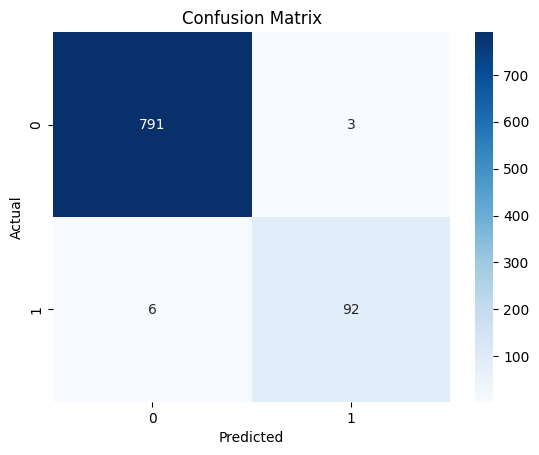

In [27]:
cm = confusion_matrix(y, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
df_1.value_counts('rulebased_label')

rulebased_label
0    809
1     98
Name: count, dtype: int64

In [ ]:
df_1.value_counts('focus_label')

focus_label
1    508
0    399
Name: count, dtype: int64

In [31]:
print(classification_report(df_1['focus_label'], df_1['rulebased_label'],target_names=['Not Focus', 'Focus']))

              precision    recall  f1-score   support

   Not Focus       0.47      0.94      0.62       397
       Focus       0.74      0.15      0.25       495

    accuracy                           0.50       892
   macro avg       0.61      0.54      0.44       892
weighted avg       0.62      0.50      0.41       892

